# DTSA-5511 Week 4 Kaggle Mini Project: Natural Language Processing with Disaster Tweets

**Genesis Zhong**

https://github.com/genesischung/5511-nlp

## Introduction

This project is a Kaggle competition (https://www.kaggle.com/competitions/nlp-getting-started/overview) with the goal of classifying Tweets about real disasters with machine learning models.

The data set was created but figure-eight, which contains about 10,000 tweets that are hand classified to either be real disasters or not.

## Setup

In [1]:
!conda activate tf
!nvidia-smi

usage: conda [-h] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'activate' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'doctor', 'env')
Mon Aug 14 15:54:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98.01              Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 

First, make sure I have the conda environment for tensorflow activated, and the GPU is properly configured. Then import all the packages necessary for this project.

In [48]:
import os
# suppress tensorflow INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# proxy needed to download from nltk
#nltk.set_proxy('http://172.18.32.1:2334')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/myzhong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/myzhong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/myzhong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We import the training data set and the test data set from Kaggle, and perform initial inspection on them.

From the information below, our  training data set contains 7613 entries, and the test set contains 3263 entries. We will be primarily working with the `text` column, which is where the tweets are stores. The `target` column is for identifying real disasters. There is no null entry in these two columns in both the train and test data set, so we will be ignoring the null entries in the `keyboard` and `location` columns. 

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Some early EDA on the data set show a lot of strange texts in the corpus, which turned out to be URL, HTML tags, and emojis. To before moving on to the actual EDA section, we should perform data cleansing.

Below is a function for data cleansing, which removes the URL, HTML tags, and emoji from the corpus. It only removes common stop words and punctuation from the corpus. It also performs lemmatization in the process.

In [7]:
# Data Cleansing    
def data_cleasning(text):
    # remove URL
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)
    
    # remove HTML tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'',text)

    # Remove emoji, from
    # https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # remove stop_words and punctuations
    stop = stopwords.words('english')       
    stpwrd = stop + list(punctuation)
    
    # lemmatization
    lemma = WordNetLemmatizer()
    word_tokens = [t for t in word_tokenize(text) if t.isalpha()]
    cleaned_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stpwrd]
    
    return " ".join(cleaned_token)



In [8]:
df_train['text'] = df_train['text'].apply(lambda x:data_cleasning(x))
df_test['text'] = df_test['text'].apply(lambda x:data_cleasning(x))

## EDA

First, I plotted the number of tweets for each `target` label. Although we have an unbalanced number of tweets, both group are large enough so there will not be a problem.

[Text(0.5, 1.0, 'Number of Tweets in Each Label (Training Set)')]

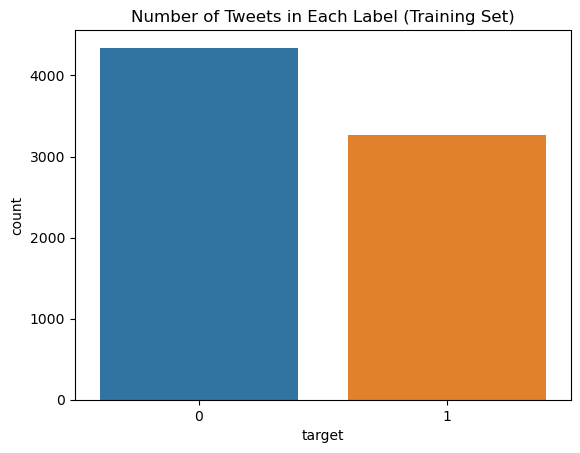

In [9]:
sns.countplot(x='target', data=df_train).set(title="Number of Tweets in Each Label (Training Set)")

Next, I plotted the distribution of tweets length in the training data set. This is to ensure we have sufficient amount of information to build models upon. And as the plot reveals, we do have some very short tweets, which will be an reasonable concern.

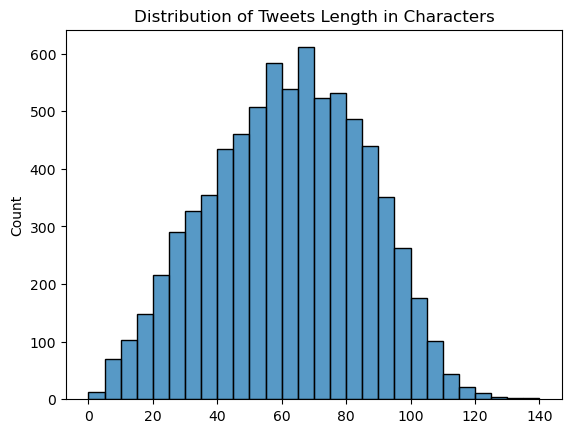

In [10]:
def plot_chars():
    """
    plot the length of tweets in charactersin the training set
    """
    lengths = [len(text) for text in df_train['text']]
    sns.histplot(x=lengths, binwidth=5).set(title="Distribution of Tweets Length in Characters")

plot_chars()

In the distribution plot above, we plotted the tweets lengths in characters, which may not be the best way of describing tweets length. So below, I plotted the tweets lengths in number of words instead. Again, approximately half the tweets are under 10 words in length. So it can be potentially difficult to extract useful information from these very short tweets.

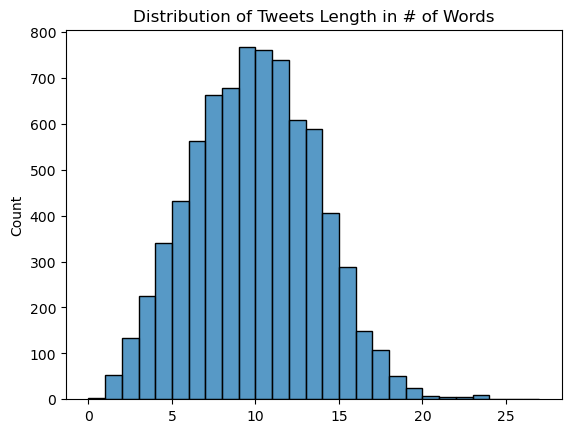

In [11]:
def plot_words():
    """
    plot the length of tweets in # of words in the training set
    """
    lengths = [len(text.split()) for text in df_train['text']]
    sns.histplot(x=lengths, binwidth=1).set(title="Distribution of Tweets Length in # of Words")

plot_words()

In [95]:
def plot_top_words(n=20, real=True):    
    vec = CountVectorizer(stop_words='english',
                         lowercase=True,
                         max_features=n)
    if real:
        X = vec.fit_transform(df_train[df_train['target']==1]['text'])
        title="Top {} Most Frequent Words in real Tweets".format(n)
    else:
        X = vec.fit_transform(df_train[df_train['target']==0]['text'])
        title="Top {} Most Frequent Words in fake Tweets".format(n)      
        
    plt.figure(figsize=(6, n/5))
    sns.barplot(x=np.sum(X.toarray(), axis=0),
                y=vec.get_feature_names_out(),
                orient='h').set(title=title)

Next, we plotted the top 50 most frequent words in real vs. fake tweets to see if we can spot any difference. From the first glance, I noticed that terms like `youtube` and `reddit`are on the top 50 plot for fake tweets, but not for real tweets. 

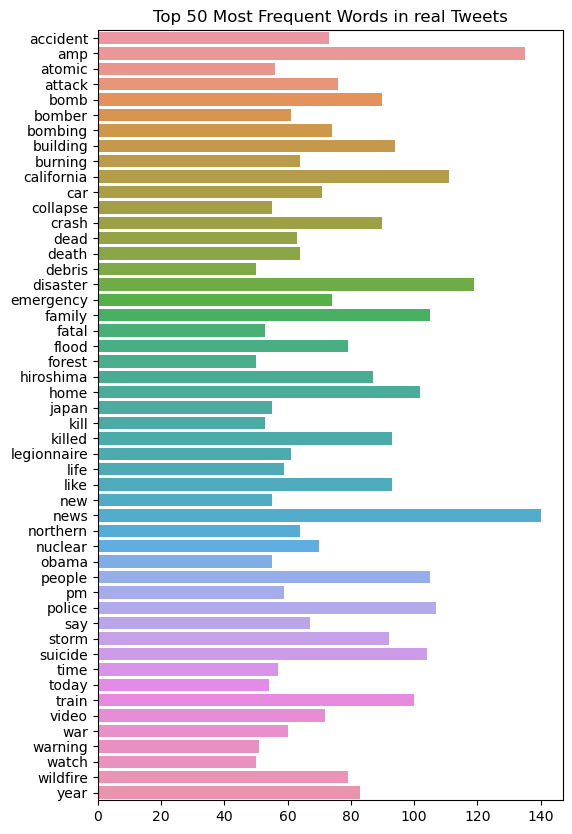

In [96]:
plot_top_words(50)

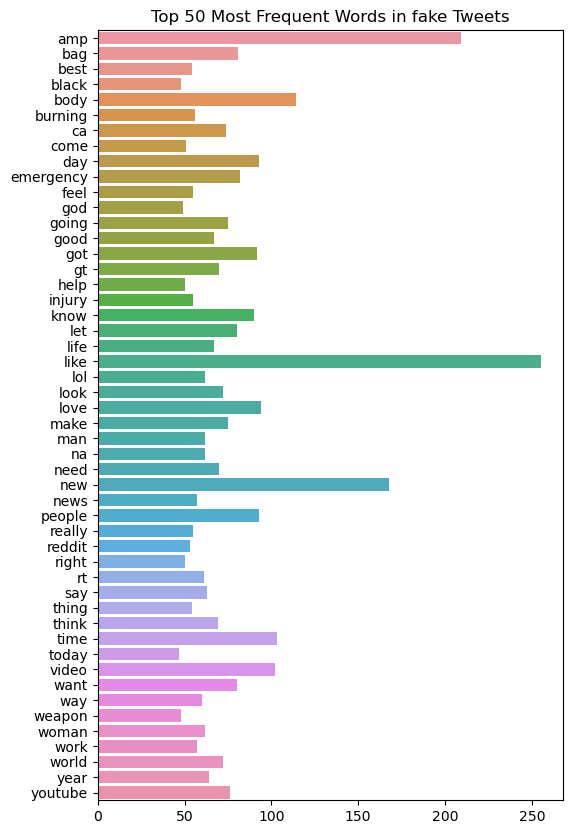

In [97]:
plot_top_words(50, False)

## Modeling 

### Tokenization

I first thought about using TF-IDF vectorizer to perform tokenization. But then it occurred to me that the model we are trying to train in this lab depends on the sequence. TF-IDF vectorizer does not preserve the sequence of the sentence, rather it is mostly based on the term frequency as suggested by its name.

As the keras Tokenizer is deprecated, I will be using a TextVectorization layer provided by keras to transform the texts in our data set to sequences of integer, with each integer representing a word. 

### Train and Valid Set Split
Since we have a test set with no `target` label, we should use a validation set to monitor the training process and evaluate the model performance. Since the training set is not very big, I chose to retain 90% of the data as the training set, and use the rest 10% as the validation set.

In [14]:
max_features = 3000
embedding_dim = 128
sequence_length = 32

train_df, valid_df = train_test_split(df_train, test_size=0.1, random_state=2023)

train_dataset = tf.data.Dataset.from_tensor_slices((np.array(train_df['text']), np.array(train_df['target'])))
valid_dataset = tf.data.Dataset.from_tensor_slices((np.array(valid_df['text']), np.array(valid_df['target'])))
text_dataset = tf.data.Dataset.from_tensor_slices(np.array(df_train['text']))

vectorize_layer = TextVectorization(
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length
)

vectorize_layer.adapt(text_dataset.batch(256))

### Model 1 - LSTM
For the first model, I wanted to build a basic RNN model with one layer of LSTM.  The structure is as followed:

- Input -> Vectorize layer
- Embedding Layer
- Dropout
- LSTM Layer
- Dropout
- Dense (Output)
  
I added dropout layer both before and after the LSTM layer for regularization to prevent overfitting. I used Adam as my optimizer and Binary Cross Entropy as my loss function.

In training the model, I used a batch size of 256 for 50 epochs. I used Early Stopping to monitor the accuracy on the validation set to avoid overtraining the model. 

In [25]:
model1 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        LSTM(embedding_dim),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)

model1.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

In [26]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 32, 128)           384128    
                                                                 
 dropout_4 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [27]:
model1_hist = model1.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Epoch 1/50
27/27 - 4s - loss: 0.6859 - accuracy: 0.5690 - val_loss: 0.6797 - val_accuracy: 0.5827 - 4s/epoch - 134ms/step
Epoch 2/50
27/27 - 0s - loss: 0.6836 - accuracy: 0.5690 - val_loss: 0.6794 - val_accuracy: 0.5827 - 418ms/epoch - 15ms/step
Epoch 3/50
27/27 - 0s - loss: 0.6834 - accuracy: 0.5690 - val_loss: 0.6792 - val_accuracy: 0.5827 - 256ms/epoch - 9ms/step
Epoch 4/50
27/27 - 0s - loss: 0.6826 - accuracy: 0.5690 - val_loss: 0.6775 - val_accuracy: 0.5827 - 223ms/epoch - 8ms/step
Epoch 5/50
27/27 - 0s - loss: 0.6754 - accuracy: 0.5690 - val_loss: 0.6513 - val_accuracy: 0.5827 - 208ms/epoch - 8ms/step
Epoch 6/50
27/27 - 0s - loss: 0.5584 - accuracy: 0.7139 - val_loss: 0.4889 - val_accuracy: 0.7756 - 225ms/epoch - 8ms/step
Epoch 7/50
27/27 - 0s - loss: 0.4290 - accuracy: 0.8170 - val_loss: 0.4503 - val_accuracy: 0.7900 - 223ms/epoch - 8ms/step
Epoch 8/50
27/27 - 0s - loss: 0.3766 - accuracy: 0.8413 - val_loss: 0.4482 - val_accuracy: 0.7992 - 233ms/epoch - 9ms/step
Epoch 9/50
27/27

In [30]:
model1.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 13ms/step - loss: 0.4599 - accuracy: 0.8058


{'loss': 0.45985180139541626, 'accuracy': 0.8057742714881897}

In [28]:
def plot_graphs(history, metric, title):
    """
    Plot selected metric from model training history
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(title)

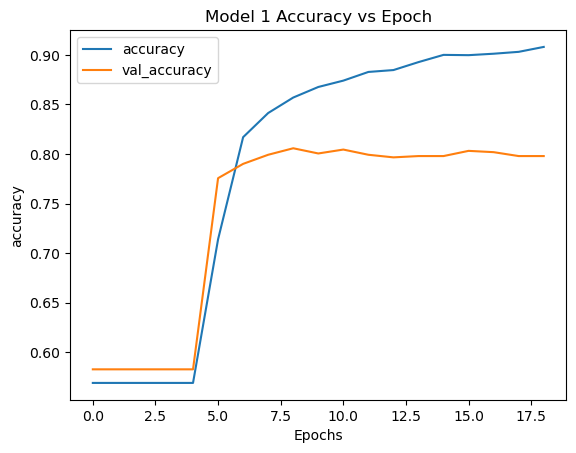

In [29]:
plot_graphs(model1_hist, 'accuracy', "Model 1 Accuracy vs Epoch")

### Model 2 - Bidirectional LSTM

Next, we try changing the architecture to use a Bidirectional LSTM instead of the unidirectional LSTM layer in the first model. Bidirectional LSTM will run inputs from both directions, not just preserving information of the past but also from the future. 

In [21]:
model2 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        Bidirectional(LSTM(embedding_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)

model2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 32, 128)           384128    
                                                                 
 dropout_2 (Dropout)         (None, 32, 128)           0         
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [23]:
model2_hist = model2.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Epoch 1/50
27/27 - 4s - loss: 0.6855 - accuracy: 0.5688 - val_loss: 0.6769 - val_accuracy: 0.5827 - 4s/epoch - 163ms/step
Epoch 2/50
27/27 - 1s - loss: 0.6789 - accuracy: 0.5690 - val_loss: 0.6723 - val_accuracy: 0.5827 - 580ms/epoch - 21ms/step
Epoch 3/50
27/27 - 1s - loss: 0.6725 - accuracy: 0.5690 - val_loss: 0.6638 - val_accuracy: 0.5827 - 586ms/epoch - 22ms/step
Epoch 4/50
27/27 - 1s - loss: 0.6592 - accuracy: 0.5769 - val_loss: 0.6463 - val_accuracy: 0.6207 - 613ms/epoch - 23ms/step
Epoch 5/50
27/27 - 1s - loss: 0.6304 - accuracy: 0.6554 - val_loss: 0.6047 - val_accuracy: 0.7126 - 595ms/epoch - 22ms/step
Epoch 6/50
27/27 - 1s - loss: 0.5781 - accuracy: 0.7235 - val_loss: 0.5542 - val_accuracy: 0.7415 - 579ms/epoch - 21ms/step
Epoch 7/50
27/27 - 1s - loss: 0.5213 - accuracy: 0.7659 - val_loss: 0.5176 - val_accuracy: 0.7612 - 572ms/epoch - 21ms/step
Epoch 8/50
27/27 - 1s - loss: 0.4718 - accuracy: 0.7935 - val_loss: 0.4737 - val_accuracy: 0.7848 - 574ms/epoch - 21ms/step
Epoch 9/50

In [24]:
model2.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 11ms/step - loss: 0.4459 - accuracy: 0.8189


{'loss': 0.4459218382835388, 'accuracy': 0.8188976645469666}

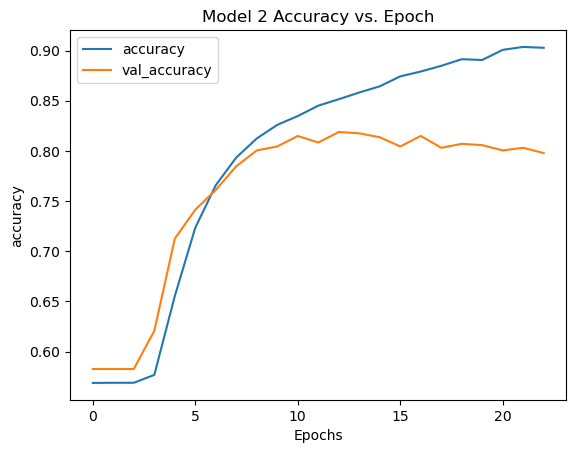

In [31]:
plot_graphs(model2_hist, 'accuracy', "Model 2 Accuracy vs. Epoch")

### Model 3 - Stacking 2x LSTM Layers
Another common approach at improving the model performance is to stack multiple LSTM layers.

For model 3 below, we stack 2 LSTM layers, and use output of the first LSTM layer as input of the second LSTM layer to hopefully help the model better predict the output.

In [35]:
model3 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        LSTM(embedding_dim, return_sequences=True),
        Dropout(0.2),
        LSTM(embedding_dim),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)

model3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

In [36]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 32, 128)           384128    
                                                                 
 dropout_8 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                      

In [37]:
model3_hist = model3.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Epoch 1/50
27/27 - 6s - loss: 0.6877 - accuracy: 0.5609 - val_loss: 0.6797 - val_accuracy: 0.5827 - 6s/epoch - 237ms/step
Epoch 2/50
27/27 - 3s - loss: 0.6834 - accuracy: 0.5690 - val_loss: 0.6792 - val_accuracy: 0.5827 - 3s/epoch - 97ms/step
Epoch 3/50
27/27 - 3s - loss: 0.6830 - accuracy: 0.5690 - val_loss: 0.6777 - val_accuracy: 0.5827 - 3s/epoch - 98ms/step
Epoch 4/50
27/27 - 3s - loss: 0.6780 - accuracy: 0.5690 - val_loss: 0.6617 - val_accuracy: 0.5827 - 3s/epoch - 98ms/step
Epoch 5/50
27/27 - 3s - loss: 0.5700 - accuracy: 0.6970 - val_loss: 0.4845 - val_accuracy: 0.7808 - 3s/epoch - 100ms/step
Epoch 6/50
27/27 - 3s - loss: 0.4278 - accuracy: 0.8124 - val_loss: 0.4532 - val_accuracy: 0.8018 - 3s/epoch - 97ms/step
Epoch 7/50
27/27 - 3s - loss: 0.3767 - accuracy: 0.8389 - val_loss: 0.4505 - val_accuracy: 0.8150 - 3s/epoch - 98ms/step
Epoch 8/50
27/27 - 3s - loss: 0.3471 - accuracy: 0.8558 - val_loss: 0.4575 - val_accuracy: 0.8176 - 3s/epoch - 98ms/step
Epoch 9/50
27/27 - 3s - loss: 

In [38]:
model3.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 56ms/step - loss: 0.4579 - accuracy: 0.8202


{'loss': 0.4578571617603302, 'accuracy': 0.8202099800109863}

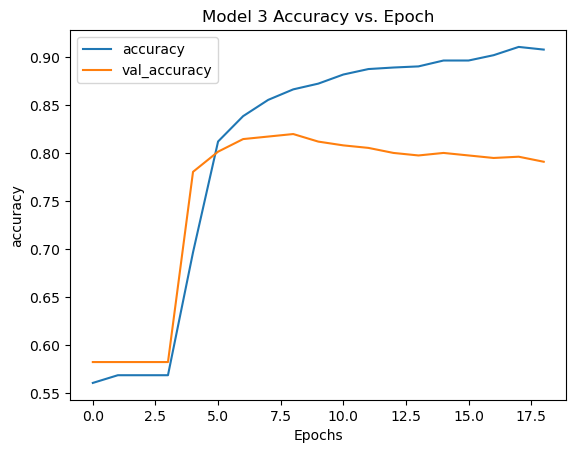

In [39]:
plot_graphs(model3_hist, 'accuracy', "Model 3 Accuracy vs. Epoch")

### Model 4 - Stacking 3x LSTM Layers

Since stacking 2x LSTM layers did seem to improve the model performance, we try stacking 3x LSTM layers in model 4 below.

In [40]:
model4 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        LSTM(embedding_dim, return_sequences=True),
        Dropout(0.2),
        LSTM(embedding_dim, return_sequences=True),
        Dropout(0.2),
        LSTM(embedding_dim),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)

model4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

In [41]:
model4.summary()
model4_hist = model4.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 32, 128)           384128    
                                                                 
 dropout_11 (Dropout)        (None, 32, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 32, 128)           131584    
                                                                 
 dropout_12 (Dropout)        (None, 32, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 32, 128)           131584    
                                                      

In [42]:
model4.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 57ms/step - loss: 0.4542 - accuracy: 0.8176


{'loss': 0.4542382061481476, 'accuracy': 0.817585289478302}

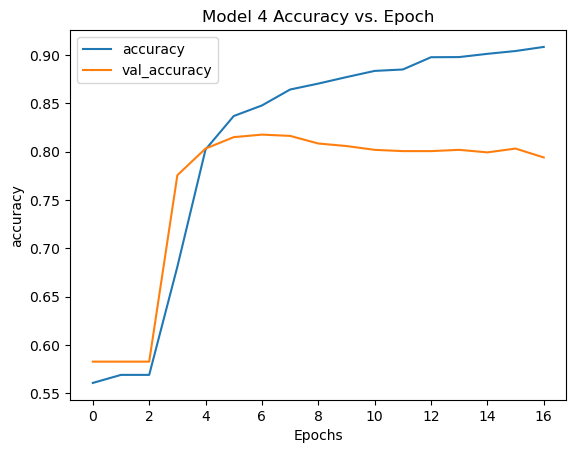

In [43]:
plot_graphs(model4_hist, 'accuracy', "Model 4 Accuracy vs. Epoch")

### Model 5 - Stacking 2x Bidirectional LSTM

Since stacking LSTM layers seems to improve the model performance, in model 5 below, we try stacking 2x Bidirectional LSTM layers.

In [44]:
model5 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        Bidirectional(LSTM(embedding_dim, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(embedding_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)

model5.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

In [45]:
model5.summary()
model5_hist = model5.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, 32, 128)           384128    
                                                                 
 dropout_15 (Dropout)        (None, 32, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32, 256)           263168    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 32, 256)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)              

In [46]:
model5.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 76ms/step - loss: 0.4394 - accuracy: 0.8189


{'loss': 0.439350426197052, 'accuracy': 0.8188976645469666}

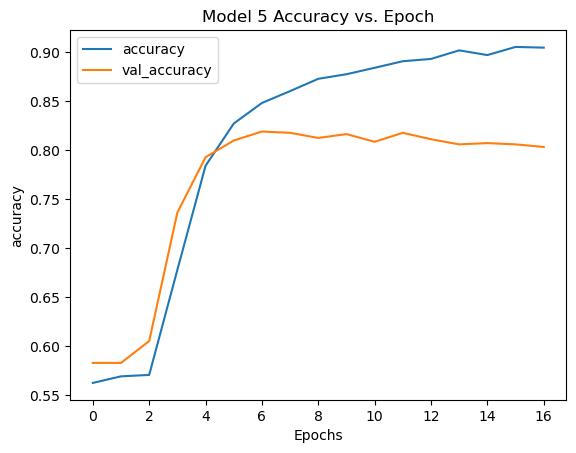

In [47]:
plot_graphs(model5_hist, 'accuracy', "Model 5 Accuracy vs. Epoch")

### Model 6- GRU

Since we are getting very similar model performance for all LSTM based models, we try a bidirectional GRU in place of the LSTM layer in model 6 below.

In [51]:
model6 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        Bidirectional(GRU(embedding_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)

model6.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

In [52]:
model6.summary()
model6_hist = model6.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding_8 (Embedding)     (None, 32, 128)           384128    
                                                                 
 dropout_21 (Dropout)        (None, 32, 128)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               198144    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [53]:
model6.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 101ms/step - loss: 0.4529 - accuracy: 0.8163


{'loss': 0.45289090275764465, 'accuracy': 0.8162729740142822}

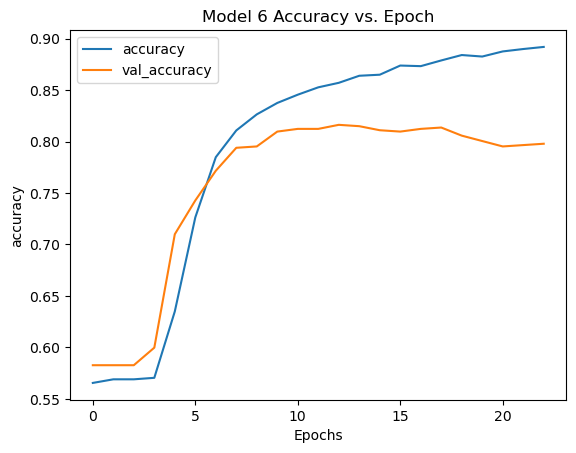

In [54]:
plot_graphs(model6_hist, 'accuracy', "Model 6 Accuracy vs. Epoch")

## Results and Discussion

| **Model** | **Architecture** | **Validation Accuracy** |
|-----------|------------------|-------------------------|
| Model 1   | LSTM             | 0.8057                  |
| Model 2   | Bi-LSTM          | 0.8189                  |
| Model 3   | 2x LSTM          | 0.8202                  |
| Model 4   | 3x LSTM          | 0.8176                  |
| Model 5   | 2x Bi-LSTM       | 0.8189                  |
| Model 6   | Bi-GRU           | 0.8163                  |

The results for all the models above are summarized in the table above.

Model 2 to Model 6 perform very similarly, with accuracy on the validation set around 0.82. Model 1 with one basic LSTM layer is slightly behind on performance, but it still has an accuracy of 0.8057 on the validation set.

From analyzing the results, we can make some observations:
- Although we saw some improvement from Model 1 to Model 2. But comparing Model 3 with Model 5, it suggests that using Bidirectional LSTM in place of unidirectional LSTM does not really improve model performance. I suspect this is due to the fact that our texts (tweets) are all very short, so we don't really benefit from the backward information flow.
- Stacking more LSTM layers does not seem to improve the model performance. This is also likely due to how short our input information are.
- GRU performs about the same as LSTM. I think this is also because of the short input length. LSTM would have performed better in complex tasks that require learning complex long-term dependencies.

## Hyperparameter Tuning

Next, we perform hyperparameter tuning on the best performing model, which is the one utilizing 2x LSTM layers.

### Sequence Length

First, I wanted to try different output sequence length for the TextVectorization layer. This will change the dimension of the output tensor from the vectorize layer, and thereby changing the input/outout dimension of the following layers.

From the results and the plot below, we can see that using too big of a sequence length will dramatically reduce the model performance. When using smaller sequence lengths, the validation accuracy seems to be about the same. When using a sequence length of 48, we get marginally better validation accuracy, so that is our best option.

In [56]:
seq_lengths = [16, 24, 32, 48, 64, 96, 128]
seq_accuracy = list()

for sequence_length in seq_lengths:
    print("Sequence Length: {}".format(sequence_length))
    vectorize_layer = TextVectorization(
        max_tokens=3000,
        output_mode="int",
        output_sequence_length=sequence_length
    )

    vectorize_layer.adapt(text_dataset.batch(256))

    model = Sequential(
        [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        LSTM(embedding_dim, return_sequences=True),
        Dropout(0.2),
        LSTM(embedding_dim),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
        ]
    )

    model.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])
    
    model.fit(
                train_dataset.batch(256),
                epochs=50, batch_size=256,
                validation_data=valid_dataset.batch(256),
                callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                verbose=0
                )
    
    results = model.evaluate(valid_dataset.batch(256), return_dict=True)
    seq_accuracy.append(results['accuracy'])

Sequence Length: 16
3/3 [==============================] - 0s 25ms/step - loss: 0.4496 - accuracy: 0.8084
Sequence Length: 24
3/3 [==============================] - 0s 34ms/step - loss: 0.4612 - accuracy: 0.8071
Sequence Length: 32
3/3 [==============================] - 0s 45ms/step - loss: 0.4428 - accuracy: 0.8071
Sequence Length: 48
3/3 [==============================] - 0s 65ms/step - loss: 0.4473 - accuracy: 0.8176
Sequence Length: 64
3/3 [==============================] - 0s 79ms/step - loss: 0.6797 - accuracy: 0.5827
Sequence Length: 96
3/3 [==============================] - 0s 123ms/step - loss: 0.6796 - accuracy: 0.5827
Sequence Length: 128
3/3 [==============================] - 0s 148ms/step - loss: 0.6798 - accuracy: 0.5827


[Text(0.5, 1.0, 'Accuracy for various Seq Length'), (0.0, 1.0)]

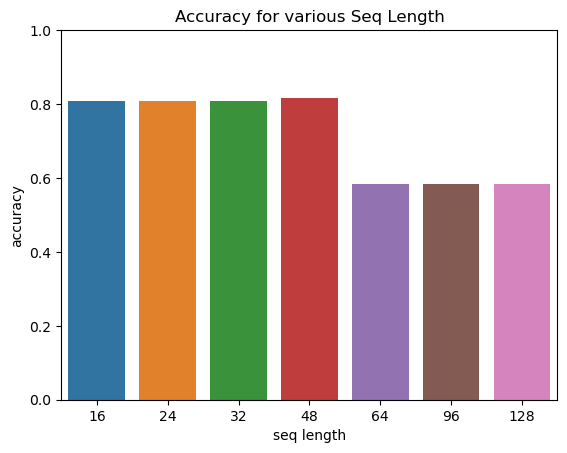

In [64]:
seq_df = pd.DataFrame({'seq length':seq_lengths, 'accuracy': seq_accuracy})
sns.barplot(data=seq_df, x='seq length', y='accuracy').set(title="Accuracy for various Seq Length", ylim=[0, 1])

### Embedding layer dimension

Next, I want to try varying the embedding layer output dimension. This changes the output of the embedding layer, and subsequently the number of units in the LSTM layer.

As shown in the plot, using an embedding output dimension of 16, the validation accuracy is quite low. Between 32 and 256, there isn't a significant difference. But the training time is much slower with larger embedding output dimensions. With a embedding_dim of 512, the validation accuracy actually starts to drop. So I believe using 128 would be a reasonable choice. 

In [66]:
embed_dim = [16, 32, 64, 128, 256, 512]
embed_dim_accuracy = list()

for embedding_dim in embed_dim:
    print("embedding_dim: {}".format(embedding_dim))
    vectorize_layer = TextVectorization(
        max_tokens=3000,
        output_mode="int",
        output_sequence_length=48
    )

    vectorize_layer.adapt(text_dataset.batch(256))

    model = Sequential(
        [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=embedding_dim),
        Dropout(0.2),
        LSTM(embedding_dim, return_sequences=True),
        Dropout(0.2),
        LSTM(embedding_dim),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
        ]
    )

    model.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])
    
    model.fit(
                train_dataset.batch(256),
                epochs=50, batch_size=256,
                validation_data=valid_dataset.batch(256),
                callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                verbose=0
                )
    
    results = model.evaluate(valid_dataset.batch(256), return_dict=True)
    embed_dim_accuracy.append(results['accuracy'])

embedding_dim: 16
3/3 [==============================] - 0s 14ms/step - loss: 0.6907 - accuracy: 0.5827
embedding_dim: 32
3/3 [==============================] - 0s 19ms/step - loss: 0.4471 - accuracy: 0.8202
embedding_dim: 64
3/3 [==============================] - 0s 32ms/step - loss: 0.4590 - accuracy: 0.8163
embedding_dim: 128
3/3 [==============================] - 0s 70ms/step - loss: 0.4567 - accuracy: 0.8215
embedding_dim: 256
3/3 [==============================] - 0s 153ms/step - loss: 0.4592 - accuracy: 0.8228
embedding_dim: 512
3/3 [==============================] - 1s 285ms/step - loss: 0.4342 - accuracy: 0.8097


[Text(0.5, 1.0, 'Accuracy for Various Embedding Dim'), (0.0, 1.0)]

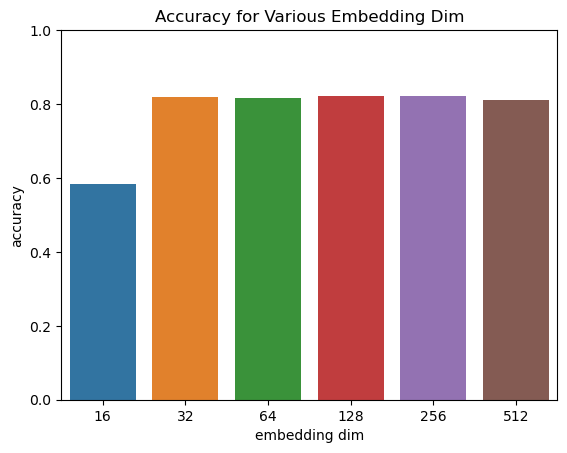

In [67]:
embeddim_df = pd.DataFrame({'embedding dim':embed_dim, 'accuracy': embed_dim_accuracy})
sns.barplot(data=embeddim_df, x='embedding dim', y='accuracy').set(title="Accuracy for Various Embedding Dim", ylim=[0, 1])

### Dropout rate

Next, I wanted to try different rates for the Dropout layers in the model. After experimenting with a range of values from 0.1 to 0.5, there does not seem to be much of a difference. The model using dropout rate of 0.4 has significant lower validation accuracy, which I cannot explain. Anyhow, based on the results here, we should be using a dropout rate of 0.3.

In [69]:
drops = [0.1, 0.2, 0.3, 0.4, 0.5]
drops_accuracy = list()

for d in drops:
    print("dropout rate: {}".format(d))
    vectorize_layer = TextVectorization(
        max_tokens=3000,
        output_mode="int",
        output_sequence_length=48
    )

    vectorize_layer.adapt(text_dataset.batch(256))

    model = Sequential(
        [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Dropout(d),
        LSTM(128, return_sequences=True),
        Dropout(d),
        LSTM(128),
        Dropout(d),
        Dense(1, activation='sigmoid')
        ]
    )

    model.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])
    
    model.fit(
                train_dataset.batch(256),
                epochs=50, batch_size=256,
                validation_data=valid_dataset.batch(256),
                callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                verbose=0
                )
    
    results = model.evaluate(valid_dataset.batch(256), return_dict=True)
    drops_accuracy.append(results['accuracy'])

dropout rate: 0.1
3/3 [==============================] - 0s 62ms/step - loss: 0.4335 - accuracy: 0.8215
dropout rate: 0.2
3/3 [==============================] - 0s 68ms/step - loss: 0.4607 - accuracy: 0.8215
dropout rate: 0.3
3/3 [==============================] - 0s 67ms/step - loss: 0.4599 - accuracy: 0.8268
dropout rate: 0.4
3/3 [==============================] - 0s 64ms/step - loss: 0.6806 - accuracy: 0.5827
dropout rate: 0.5
3/3 [==============================] - 0s 64ms/step - loss: 0.4550 - accuracy: 0.8123


[Text(0.5, 1.0, 'Accuracy for Various Dropout Rate'), (0.0, 1.0)]

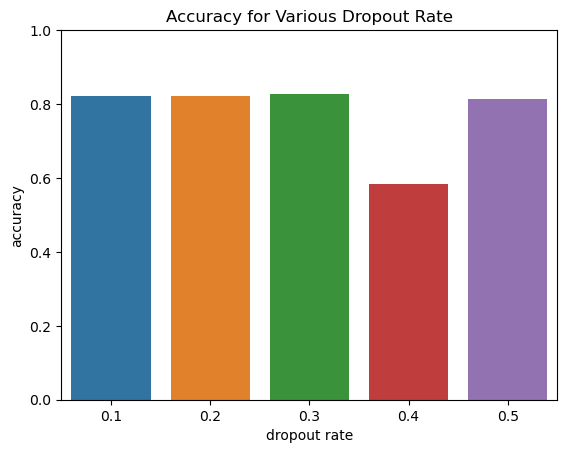

In [70]:
drops_df = pd.DataFrame({'dropout rate':drops, 'accuracy': drops_accuracy})
sns.barplot(data=drops_df, x='dropout rate', y='accuracy').set(title="Accuracy for Various Dropout Rate", ylim=[0, 1])

## Final Model and Submission

With the best set of hyperparameters found above, we trained the model below. Somehow, the accuracy on the validation set is even lower than what we achieved with the original model 3.

In [71]:
vectorize_layer = TextVectorization(
        max_tokens=3000,
        output_mode="int",
        output_sequence_length=48
    )

vectorize_layer.adapt(text_dataset.batch(256))

model_best = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(128),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

model_best.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(0.0001),
               metrics=['accuracy'])

model_best_hist = model_best.fit(
                         train_dataset.batch(256),
                         epochs=50, batch_size=256,
                         validation_data=valid_dataset.batch(256),
                         callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
                         verbose=2
                        )

Epoch 1/50
27/27 - 7s - loss: 0.6879 - accuracy: 0.5612 - val_loss: 0.6798 - val_accuracy: 0.5827 - 7s/epoch - 248ms/step
Epoch 2/50
27/27 - 4s - loss: 0.6838 - accuracy: 0.5690 - val_loss: 0.6800 - val_accuracy: 0.5827 - 4s/epoch - 151ms/step
Epoch 3/50
27/27 - 4s - loss: 0.6838 - accuracy: 0.5690 - val_loss: 0.6800 - val_accuracy: 0.5827 - 4s/epoch - 145ms/step
Epoch 4/50
27/27 - 4s - loss: 0.6838 - accuracy: 0.5690 - val_loss: 0.6799 - val_accuracy: 0.5827 - 4s/epoch - 147ms/step
Epoch 5/50
27/27 - 4s - loss: 0.6838 - accuracy: 0.5690 - val_loss: 0.6799 - val_accuracy: 0.5827 - 4s/epoch - 142ms/step
Epoch 6/50
27/27 - 4s - loss: 0.6834 - accuracy: 0.5690 - val_loss: 0.6798 - val_accuracy: 0.5827 - 4s/epoch - 140ms/step
Epoch 7/50
27/27 - 4s - loss: 0.6835 - accuracy: 0.5690 - val_loss: 0.6797 - val_accuracy: 0.5827 - 4s/epoch - 142ms/step
Epoch 8/50
27/27 - 4s - loss: 0.6832 - accuracy: 0.5690 - val_loss: 0.6791 - val_accuracy: 0.5827 - 4s/epoch - 140ms/step
Epoch 9/50
27/27 - 4s - 

In [72]:
model_best.evaluate(valid_dataset.batch(256), return_dict=True)

3/3 [==============================] - 0s 60ms/step - loss: 0.4295 - accuracy: 0.8150


{'loss': 0.42953670024871826, 'accuracy': 0.8149606585502625}

We plot the accuracy and loss for the best model below, trying to find an explanation for why it performed worse than the un-optimized model. We can see that the accuracy suddenly increased, and loss dramatically dropped around epoch 8, suggesting the learning rate was too high. However, the accuracy and loss were relatively flat before epoch 8, suggesting the learning rate was too low.

I tried changing the input learning rate for the Adam Optimizer, but I was not getting any better result. Regardless of what initial learning rate I use, Adam Optimizer always adapt the learning rate. So I should probably use some different optimizer or try applying weight decay.

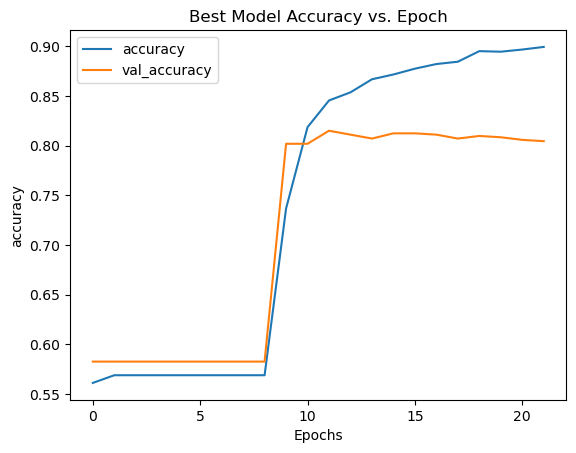

In [73]:
plot_graphs(model_best_hist, 'accuracy', "Best Model Accuracy vs. Epoch")

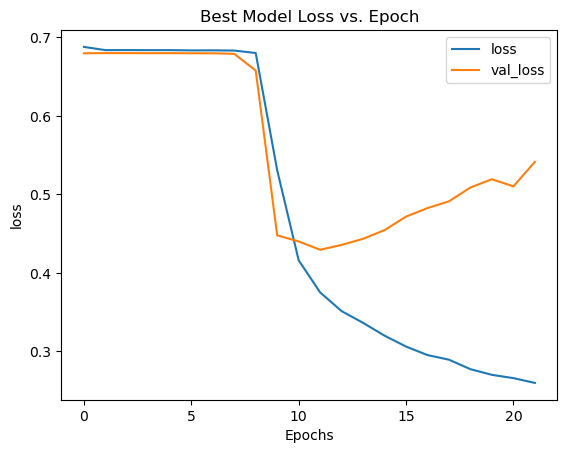

In [98]:
plot_graphs(model_best_hist, 'loss', "Best Model Loss vs. Epoch")

Nonetheless, I still make predictions on the test set using this best model. And it scored `0.79957` on Kaggle.

For comparison, I also make predictions on model 3, which scored `0.79098`. So despite scoring lower for the validation data, the optimized model did perform better on the test set.

In [81]:
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(df_test['text'])))
preds = model_best.predict(test_dataset.batch(256))
preds = (preds > 0.5).astype(int)
preds.flatten()

13/13 [==============================] - 1s 84ms/step


array([1, 1, 1, ..., 1, 1, 1])

In [82]:
submission = pd.DataFrame({'id':np.array(df_test['id']), 'target':preds.flatten()})
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [84]:
submission.target.value_counts()

target
0    2143
1    1120
Name: count, dtype: int64

In [85]:
submission.to_csv("submission.csv", index=False, header=True)

![model_best](modelbest.png)

In [88]:
def generate_submission(model, filename):
    preds = model.predict(test_dataset.batch(256))
    preds = (preds > 0.5).astype(int)
    preds.flatten()
    submission = pd.DataFrame({'id':np.array(df_test['id']), 'target':preds.flatten()})
    submission.to_csv(filename, index=False, header=True)

In [89]:
generate_submission(model3, "model3.csv")

13/13 [==============================] - 1s 57ms/step


![model3](model3.png)

## Conclusion

In this project, we experiment with different architectures of RNN models for this text classification task with moderate success. We did not improve the model performance by much in this project, which is something we should work on in the future. 

Other than what has been discussed above, one way of improving the model is to use a pre-trained model. The starter notebook on Kaggle uses a pre-trained DistilBERT model, and it is able to achieve a score of 0.83512 without much tuning. Another approch is using tansformers, which is another type of neural network popular in the field of NLP.

## References

- Frassetto, S. (2020, August 3). You should try the new tensorflow’s textvectorization layer. Medium. https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee
- Figure-eight. (n.d.). Disater Tweeks Dataset. Kaggle. https://www.kaggle.com/competitions/nlp-getting-started/data